<a href="https://colab.research.google.com/github/LoliamShely/Face-generation-with-GAN/blob/master/GAN_on_faces_working!!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import zipfile
import os
from scipy import misc
import cv2
import numpy as np

from time import time

from IPython.core.debugger import Tracer

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Conv2D, MaxPool2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt
import os
from keras.layers.convolutional import UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers


Using TensorFlow backend.


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
!echo '{"username":"your_username","key":"your_key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d jessicali9530/celeba-dataset -f img_align_celeba.zip

 99% 1.33G/1.34G [00:19<00:00, 77.4MB/s]
100% 1.34G/1.34G [00:19<00:00, 73.4MB/s]


In [0]:
!ls /content
!mkdir images 

img_align_celeba.zip  sample_data


In [0]:
os.environ["KERAS_BACKEND"] = "tensorflow"

## Helpers

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def resize(img):
  return cv2.resize(img, dsize=(64,78))#, interpolation=cv2.INTER_CUBIC)

def extract_images():
  print("Extracting...")
  f = zipfile.ZipFile("/content/img_align_celeba.zip", 'r')
  f.extractall("images")
  f.close()
  del(f)
  print("Extracted.")
  ! mv images/img_align_celeba ./images_extracted
  print("Folder moved to './images_extracted'.")

def load_images(num_of_images=50000, grayscale=False):
  print("Loading images...")
  ret = []
  ma = num_of_images
  for image in os.listdir("images_extracted"):
    if(ma <= 0):
      return np.array(ret)
    c_image = "images_extracted/{}".format(image)
    color_img = misc.imread(c_image)
    if grayscale:
      color_img = rgb2gray(color_img)
    color_img = resize(color_img)
    ret.append(color_img)
    del(c_image)
    ma -= 1

In [0]:
extract_images()

Extracting...
Extracted.
Folder moved to './images_extracted'.


### showImages

In [0]:
def showImages(epoch, generator, rgb=False):
  noise = np.random.normal(0,1, size=[10, noise_dim])
  images = generator.predict(noise)
  images = images.reshape(images.shape[0], height, width, channels)
  
  plt.figure(figsize=(10,3))
  
  for indx in range(images.shape[0]):
    plt.subplot(1,10, indx+1)
    if rgb:
      plt.imshow(denormalize_rgb(images[indx]),interpolation='nearest')
    else:
      plt.imshow(images[indx].reshape(height,width), cmap='gray',interpolation='nearest')
    plt.axis('off')
  plt.show()    


### Load Images

In [0]:
data = load_images(num_of_images=30000) # takes 10 mins to load

# The dimension of our random noise vector.
noise_dim = 100
width = data.shape[2]
height = data.shape[1]
channels = 3

Loading images...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [0]:
def denormalize_rgb(m):
  return (m*127+127).astype('u1')

In [0]:
class AutoObj(object):
  def __init__(self, **kwargs):
    self.__dict__.update(**kwargs)
    

### getX_1D, 2D

In [0]:
def getX_2D():
  return (data.astype(np.float32)-127.5)/127.5

def getX_1D():
  ret = getX_2D()
  ret = ret.reshape(ret.shape[0], -1)    
  return ret

In [0]:
def gen_optimizer():
  return Adam(lr=0.0002, beta_1=0.5)

### gen_generator_1D

In [0]:
def gen_generator_1D_working(optimizer):
  model = Sequential()
  
  model.add(Dense(256, input_dim=noise_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2)) # like alpha=0.2
  
  model.add(Dense(512))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2))
  
  model.add(Dense(1024))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2))
  
  model.add(Dense(height*width*channels, activation='tanh'))
#   model.add(Reshape((height,width,channels))) # remove if not
#   model.compile(loss='binary_crossentropy', optimizer=optimizer)
  
  return model
  
def gen_generator_1D(optimizer):
  model = Sequential()
  
  model.add(Dense(256, input_dim=noise_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2)) # like alpha=0.2
  
  model.add(Dense(height*width*channels, activation='tanh'))
  
  return model
  

### gen_generator_2D

In [0]:
def gen_generator_2D(optimizer):
  model = Sequential()
  
  model.add(Dense(256, input_dim=noise_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2)) 
  
  model.add(Dense(512))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2))
  
  model.add(Dense(1024))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(0.2))
  
  model.add(Dense(height*width*channels, activation='tanh'))
  model.add(Reshape((height,width,channels))) # remove if not
  
  return model
  

### gen_discriminator_1D

In [0]:
def gen_discriminator_1D(optimizer):
  model = Sequential()
  
  model.add(Dense(1024, input_dim=height*width*channels, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
  
  return model


def gen_discriminator_1D_conv(optimizer):
  model = Sequential()
  model.add(Reshape((height, width, channels)))

  model.add(Conv2D(
      filters=32,
      kernel_initializer=initializers.RandomNormal(stddev=0.02), 
      kernel_size=(5,5), 
      padding='SAME', 
      input_shape=(height,width,channels), 
      activation=LeakyReLU(0.2),
  ))
  model.add(MaxPool2D(strides=2))
  model.add(Dropout(0.3))

  model.add(Conv2D(
      filters=64, 
      kernel_size=(5,5), 
      padding='SAME',  
      activation=LeakyReLU(0.2)
  ))
  model.add(MaxPool2D(strides=2))
  model.add(Dropout(0.3))

  model.add(Conv2D(
      filters=128,
      kernel_size=(5,5), 
      padding='SAME',  
      activation=LeakyReLU(0.2)
  ))
  model.add(MaxPool2D(strides=2))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(128, activation=LeakyReLU(0.2)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

### gen_discriminator_2D

In [0]:
def gen_discriminator_2D_conv(optimizer):
  model = Sequential()
  model.add(Conv2D(
      filters=32,
      kernel_initializer=initializers.RandomNormal(stddev=0.02), 
      kernel_size=(5,5), 
      padding='SAME', 
      input_shape=(height,width,channels), 
      activation=LeakyReLU(0.2),
  ))
  model.add(MaxPool2D(strides=2))
  model.add(Dropout(0.3))

  model.add(Conv2D(
      filters=64,
      kernel_size=(5,5), 
      padding='SAME',  
      activation=LeakyReLU(0.2)
  ))
  model.add(MaxPool2D(strides=2))
  model.add(Dropout(0.3))

  model.add(Conv2D(
      filters=128,
      kernel_size=(5,5), 
      padding='SAME',  
      activation=LeakyReLU(0.2)
  ))
  model.add(MaxPool2D(strides=2))
  model.add(Dropout(0.3))
  # 8x5x128
  model.add(Dense(128, activation=LeakyReLU(0.2)))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

def gen_discriminator_2D(optimizer):
  model = Sequential()
  
  # 64x78x3
  model.add(Conv2D(
      filters=64,
      kernel_initializer=initializers.RandomNormal(stddev=0.02), 
      kernel_size=(3,3), 
      padding='SAME', 
      input_shape=(height,width,channels), 
      activation='relu'
  ))
#   model.add(MaxPool2D(strides=2))
#   model.add(Dropout(0.3))
  model.add(Conv2D(
      filters=32,#128, 
      kernel_size=(3,3), 
      padding='SAME',  
      activation='relu',#LeakyReLU(0.2)
  ))
#   model.add(MaxPool2D(strides=2))
#   model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
  
  return model



### gen_gan_net

In [0]:
def gen_gan_net(discriminator, noise_dims, generator, optimizer):
  discriminator.trainable = False
  gan_input = Input(shape=(noise_dims,))
  
  X = generator(gan_input)

  gan_output = discriminator(X)
  gan = Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
  
  return gan

### train_1D

In [0]:
def train_1D(epochs, batch_size, show_interval,  generator,   discriminator):
  
  X_train = getX_1D()
  
  batch_count = X_train.shape[0] / batch_size
  
  gan = gen_gan_net(discriminator, noise_dim, generator, adam)
  
  for epoch in range(1, epochs+1):
    print("="*30 + "Epoch " + str(epoch) + "="*30)
    d_loss = g_loss = 0
    
    for indx in range(int(batch_count)):
      noise = np.random.normal(0,1, size=[batch_size, noise_dim])
      real_images = X_train[np.random.randint(0,X_train.shape[0], size=batch_size)] # get random images from X_train. len is batch_size
      
      fake_images = generator.predict(noise)
      
#       print("Fake shape: {}\tReal shape:{}".format(fake_images.shape,real_images.shape))
      X = np.concatenate([real_images, fake_images])
      
      y_dis = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
      
      discriminator.trainable = True
      d_loss += discriminator.train_on_batch(X, y_dis)[0]
      
      
      
#       # train the generator
      noise = np.random.normal(0,1, size=[batch_size, noise_dim])
      y_gen = np.ones(batch_size)
#       print("noise shape: {}\ty_gen shape: {}".format(noise.shape, y_gen.shape))
      discriminator.trainable = False
      g_loss += gan.train_on_batch(noise, y_gen)[0]

    print("g_loss={}\td_loss={}".format(g_loss/batch_count, d_loss/batch_count))
    
      
    if epoch % show_interval == 0:
      showImages(epoch, generator, rgb=True)
      
  return AutoObj(
      gan=gan, 
      disc=discriminator,
      gene=generator
  )

adam = Adam(lr=0.0002)
def train_1D_working(epochs, batch_size, show_interval,  generator,   discriminator):
  
  X_train = getX_1D()
  
  batch_count = X_train.shape[0] / batch_size
  
  gan = gen_gan_net(discriminator, noise_dim, generator, adam)
  
  for epoch in range(1, epochs+1):
    print("="*30 + "Epoch " + str(epoch) + "="*30)
    d_loss = g_loss = 0
    
    for indx in range(int(batch_count)):
      noise = np.random.normal(0,1, size=[batch_size, noise_dim])
      real_images = X_train[np.random.randint(0,X_train.shape[0], size=batch_size)] # get random images from X_train. len is batch_size
      
      fake_images = generator.predict(noise)
      
#       print("Fake shape: {}\tReal shape:{}".format(fake_images.shape,real_images.shape))
      X = np.concatenate([real_images, fake_images])
      
      y_dis = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
      
      discriminator.trainable = True
      d_loss += discriminator.train_on_batch(X, y_dis)[0]
      
      
      
#       # train the generator
      noise = np.random.normal(0,1, size=[batch_size, noise_dim])
      y_gen = np.ones(batch_size)
#       print("noise shape: {}\ty_gen shape: {}".format(noise.shape, y_gen.shape))
      discriminator.trainable = False
      g_loss += gan.train_on_batch(noise, y_gen)[0]

    print("g_loss={}\td_loss={}".format(g_loss/batch_count, d_loss/batch_count))
    
      
    if epoch % show_interval == 0:
      if channels!=1:
        showImages(epoch, generator, rgb=True)
      else:
        showImages(epoch, generator)
      
  return AutoObj(
      gan=gan, 
      disc=discriminator,
      gene=generator
  )


Instructions for updating:
Colocations handled automatically by placer.


### train_2D

In [0]:
def train_2D(epochs, batch_size, show_interval, generator, discriminator):
  
  X_train = getX_2D()
  
  batch_count = X_train.shape[0] / batch_size

  adam = gen_optimizer()

  gan = gen_gan_net(discriminator, noise_dim, generator, adam)
  
  datagen = ImageDataGenerator(
      rotation_range=7,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.01,
      zoom_range=[0.9, 1.1],
      horizontal_flip=True,
      vertical_flip=False,      
  )
  # fit parameters from data
  datagen.fit(X_train)
  # configure batch size and retrieve one batch of images
  epoch = 0
  logs = []
  for epoch in range(1, epochs+1):
    g_loss = d_loss = 0
    print("="*30 + "Epoch " + str(epoch) + "="*30)
    nbatch = 0
    for X_batch in datagen.flow(X_train, batch_size=batch_size):
      if nbatch >= batch_count:
        break
      nbatch += 1

      if False: # Debug ImageDataGenerator
        plt.figure()
        for indx in range(batch_size):
          img = X_batch[indx]
          plt.subplot(5,6,indx+1)

          plt.imshow(denormalize_rgb(img));
        print(img[:10,:10])
        return

      n = X_batch.shape[0]
      noise = np.random.normal(0,1, size=[n, noise_dim])
      real_images = X_batch

      fake_images = generator.predict(noise)
    
      
      
#       print("Fake shape: {}\tReal shape:{}".format(fake_images.shape,real_images.shape))
      X = np.concatenate([real_images, fake_images])
      y_dis = np.concatenate([np.ones(n), np.zeros(n)])
      
      discriminator.trainable = True
#       print('X:{}\ty_dis:{}'.format(str(X.shape), str(y_dis.shape)))
      d_loss += discriminator.train_on_batch(X, y_dis)[0]
      

      
      # train the generator
      noise = np.random.normal(0,1, size=[n, noise_dim])
      y_gen = np.ones(n)
#       print("noise shape: {}\ty_gen shape: {}".format(noise.shape, y_gen.shape))
      discriminator.trainable = False
      g_loss += gan.train_on_batch(noise, y_gen)[0]
    
    print("g_loss={}\td_loss={}".format(str(g_loss/nbatch),str(d_loss/nbatch)))
    
    if epoch % show_interval == 0:
      showImages(epoch, generator, rgb=True)
      
      
  return AutoObj(
      gan=gan, 
      disc=discriminator,
      gene=generator
  )

      

## Run

### Run 1D version

In [0]:
GANI = train_1D_working(
    epochs=30,
    batch_size=32,
    show_interval=1,
    generator = gen_generator_1D(Adam(0.0005)),
    discriminator = gen_discriminator_1D_conv(
        Adam(
            lr=0.0002, 
            beta_1=0.5
        )
    )
)

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


==============================Epoch 1==============================


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

### Run 2D version

#### Experimental results:
##### Exp 1 - Good and stable gen-desc loss balance:
- 50 epochs
- 3000 images
- Very stable DG matchup
- Generated images are not very visually appealing

code:


```
np.random.seed(16)
GAN = train_2D(
    epochs=50,
    batch_size=64,
    show_interval=1,
    generator = gen_generator_2D(
        Adam(
            lr=0.02,
            beta_1=0.5
        )
    ),
    discriminator = gen_discriminator_2D_conv(
        Adam(
            lr=0.00004, 
            beta_1=0.5
        )
    )
)
```




/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


==============================Epoch 1==============================
g_loss=0.8112246475494238	d_loss=0.6458015183904278


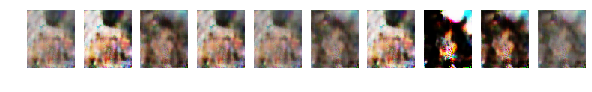

==============================Epoch 2==============================
g_loss=0.7112331999136187	d_loss=0.6996213440447728


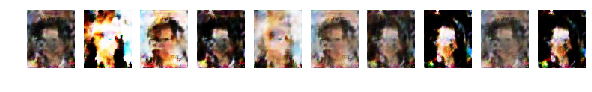

==============================Epoch 3==============================
g_loss=0.6996654836353717	d_loss=0.6958176187360718


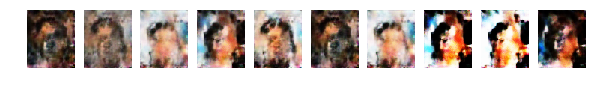

==============================Epoch 4==============================
g_loss=0.9456652344416961	d_loss=0.5783285744535898


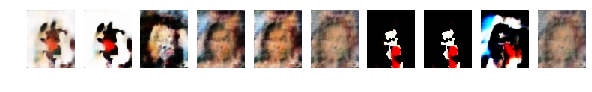

==============================Epoch 5==============================


KeyboardInterrupt: ignored

In [0]:
np.random.seed(16)
GAN = train_2D(
    epochs=50,
    batch_size=64,
    show_interval=1,
    generator = gen_generator_2D(
        Adam(
            lr=0.02,
            beta_1=0.5
        )
    ),
    discriminator = gen_discriminator_2D_conv(
        Adam(
            lr=0.00004, 
            beta_1=0.5
        )
    )
)

In [0]:
for indx in range(30):
  plt.subplot(5,6,indx+1)
  plt.imshow(data[indx])